In [36]:
import pandas as pd
import cobra
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import linprog
import scipy
import mip

def save_dict(data, name):
    with open(name, 'w' ) as file:
        json.dump( data, file )

# Community modeling

In this notebook we will implement a method to create community models of two or more species specific metabolic models using cobrapy.

In [37]:
model_DP = cobra.io.read_sbml_model("models/consistent_DP_SNM.xml")
model_SA = cobra.io.read_sbml_model("models/consistent_iYS854_SNM.xml")
print("Growth: ", model_DP.slim_optimize())
print("Growth: ", model_SA.slim_optimize())

Growth:  0.2823653925322476
Growth:  2.558694612613393


In [38]:
for rec in model_SA.reactions:
    rec.lower_bound = max(rec.lower_bound, -1000)
    rec.upper_bound = min(rec.upper_bound, 1000)

In [39]:
snm3 = pd.read_csv("SNM3.csv", sep =";")
snm3.head()

,Compound,BiGG,ModelSeed,KEGG
0,Alanine,ala__L,cpd00035,C00041
1,Arginine,arg__L,cpd00051,C00062
2,Cysteine,cys__L,cpd00084,C00097
3,Glutamic acid,glu__L,cpd00023,C00025
4,Glycine,gly,cpd00033,C00037


In [40]:
BIOMASS_DP = "Growth" 
BIOMASS_SA = "BIOMASS_iYS_wild_type"
models = [model_DP.copy(), model_SA.copy()]

In [41]:
import json
compm_SA = json.loads(open("compm_SA.json").read())
compm_DP = json.loads(open("compm_DP.json").read())
compm = dict(list(compm_SA.items()) + list(compm_DP.items()))

## 1) Constructing of community model explicitely

Here we introduce only shuttle reactions for reactions that are common in the uptake/sekretion reactions of the individual models!

In [42]:
def create_stoichiometry_matrix(model):
    metabolites = model.metabolites 
    reactions = model.reactions 
    S = np.zeros((len(metabolites), len(reactions)))
    
    met_id = dict()
    rec_id = dict()
    for i,reaction in enumerate(model.reactions):
        rec_id[reaction.id] = i
        for metabolite, stoich in reaction.metabolites.items():
            met_id[metabolite.id] = int(metabolites.index(metabolite))
            S[metabolites.index(metabolite), i] = stoich
    return S, met_id, rec_id 

In [43]:
class Model():
    def __init__(self, model, biomass_function):
        """ This is a new class of metabolic model, capable of flux balance analysis
        Attributes:
        models (list): CobraPy models of single organisms which will be used in construction
        biomass_reactions (list): List of strings containing the ids for the growth reactions
        """
        self.biomass_function = biomass_function
        self.model = model
        self.id = model.id
        # Compute stoichimetry_matrix
        S, met_id, rec_id = create_stoichiometry_matrix(model)
        self.num_reactions = S.shape[1]
        self.num_metabolites = S.shape[0]
        self.stoichiometry_matrix = scipy.sparse.csr_matrix(S)
        self.met_id = met_id
        self.rec_id = rec_id 
        # Set objective
        idx = self.rec_id[biomass_function]
        c = np.zeros(self.num_reactions)
        c[idx] = 1
        self.objective_c = c
        # Set bounds
        self._reset_bounds()
    
    @property
    def reactions(self):
        return self.model.reactions
    @property
    def exchanges(self):
        return self.model.exchanges
    @property
    def metabolites(self):
        return self.model.metabolites
    @property
    def medium(self):
        return self.model.medium

    def set_medium(self, medium):
        ex_ids = [ex.id for ex in self.exchanges]
        new_med = {}
        for key,val in medium.items():
            if key in ex_ids:
                new_med[key] = val
        self.model.medium = new_med
        self._reset_bounds()
        
    def optimize(self, disp=False):
        sol = linprog(-self.objective_c, A_eq=self.stoichiometry_matrix, b_eq=np.zeros(self.num_metabolites), bounds=self.bounds, method="highs", options={"disp":disp})
        sol["fun"] = -sol["fun"] # As we have to minimize
        return sol 
    
    def slim_optimize(self, disp=False):
        sol = self.optimize(disp=disp)
        return sol["fun"]

    def summary(self):
        sol = self.optimize()
        flux = sol["x"]
        ex_ids = [ex.id for ex in self.exchanges]
        fluxes = []
        for ex in ex_ids:
            idx = self.rec_id[ex]
            fluxes.append(flux[idx])
        summary_df = pd.DataFrame({"Exchange reaction": ex_ids, "Flux": fluxes})
        summary_df.sort_values(["Flux"], inplace=True)
        return summary_df

    def _reset_bounds(self):
        self.bounds = []
        for rec in self.model.reactions:
            self.bounds.append((rec.lower_bound, rec.upper_bound))

    def __add__(self, model2):
        """ Adding another model creates a community model """
        return CommunityModel([self,model2], [1.,1.])
    

In [44]:
model_DP.medium = compm_DP 
model_SA.medium = compm_SA

In [45]:
model1 = Model(model_DP, BIOMASS_DP)
model2 = Model(model_SA, BIOMASS_SA)

$$ \max \sum_{i=1}^n \theta_i \text{ subject to }$$

$$ SV = 0, V_{j,min} \leq V_j \leq V_{j, max}, V_{Growth} \geq MBR/10 , V_{i, COOPM} + V_{i, min}\theta_i \geq V_{i,\min} $$

In [46]:
from mip import Model, xsum, maximize, BINARY

model1.set_medium(compm)
model2.set_medium(compm)

S1 = model1.stoichiometry_matrix.todense()
S1_dict = model1.rec_id 
bounds1 = model1.bounds 
obj1 = np.where(model1.objective_c > 0)[0][0]

S2 = model2.stoichiometry_matrix.todense()
S2_dict = model2.rec_id 
bounds2 = model2.bounds
obj2 = np.where(model2.objective_c > 0)[0][0]

In [47]:
from mip import Model, xsum, maximize, BINARY

comm_model = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    x = comm_model.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [comm_model.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [comm_model.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    comm_model.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    comm_model.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(compm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        comm_model.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        comm_model.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        comm_model.add_constr(-x_sh[i] + x2[idx] == 0)


In [48]:
def get_exchange_flux(S_dict, x):
    dic ={}
    for key, val in S_dict.items():
        if "EX_" in key:
            dic[key] = x[val].x
    return dic

def get_medium(x):
    dic = {}
    for key, val in x.items():
        dic[key] = val.lb
    return dic

First looking at the convex combinaiton

In [49]:
alphas = np.linspace(0,1,10)
DP_growth = []
SA_growth = []
coopms = []
for a in alphas:
    comm_model.objective = maximize(a*x1[obj1] + (1-a)*x2[obj2])
    comm_model.optimize()
    DP_growth.append(x1[obj1].x)
    SA_growth.append(x2[obj2].x)
    

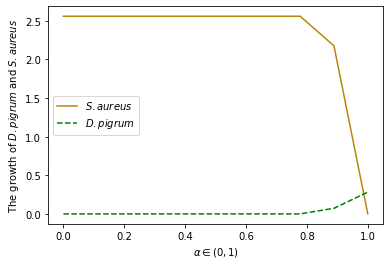

In [50]:
plt.plot(alphas, SA_growth, 'darkgoldenrod')
plt.plot(alphas, DP_growth, 'g--')
plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
title_font = {'fontname':'Arial', 'size':'14', 'color':'black', 'weight':'normal'} 
#plt.title('The interaction between D. pigrum and S.aureus in the poor community', **title_font)
plt.xlabel(r"$\alpha\in (0,1)$")
plt.ylabel('The growth of $\it{D. pigrum}$ and $\it{S.aureus}$')
plt.savefig("SA_DP_growth_COMPM_respectAlpha", bbox_inches='tight', dpi=1000)
plt.show()

In [51]:
# SA dominates
w1 = 0.85
w2 = 0.15

comm_model.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
comm_model.optimize()
print(x1[obj1].x)
print(x2[obj2].x)
minMBR = (w1*x1[obj1].x + w2*x2[obj2].x)/10
print(minMBR)

0.07290151281797531
2.175506751511212
0.03882922986219608


In [52]:
# Check for medium
medium = get_medium(x_sh_dict)
for key in medium:
    assert key in compm

In [53]:
for key, val in get_exchange_flux(S2_dict, x2).items():
    if val < 0:
        assert key in medium
for key, val in get_exchange_flux(S1_dict, x1).items():
    if val < 0:
        if not key in medium:
            print(key, val)

In [54]:
m = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in compm.items():
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    x = m.add_var(lb=V_min, ub=100)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [m.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [m.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    m.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    m.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(compm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        m.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        m.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        m.add_constr(-x_sh[i] + x2[idx] == 0)

# thetas
thetas = []
thetas_constraint = []
for x in x_sh:
    V_min = -10
    if key == "EX_o2_e":
        V_min = -20
    if "_fe" in key:
        V_min = -0.1
    theta = m.add_var(var_type=BINARY)
    thetas_constraint += [m.add_constr(x + V_min*theta >= V_min)]
    thetas.append(theta)
# Both must grow
growth_const1 = m.add_constr(x1[obj1] >= minMBR)
growth_const2 = m.add_constr(x2[obj2] >= minMBR)

In [55]:
m.objective = maximize(xsum(thetas))
m.optimize()
print(x1[obj1].x)
print(x2[obj2].x)

0.038829229862196085
0.03882922986219608


In [56]:
flux = [x.x for x in x_sh]
coopm = dict()
for f, key in zip(flux, compm.keys()):
    if f < 0:
        coopm[key] = abs(f)
save_dict(coopm, "COOPM_COM")
coopm

{'EX_zn2_e': 0.0012493252909339299,
 'EX_na1_e': 0.0807694582637043,
 'EX_thm_e': 2.570329746533323e-05,
 'EX_o2_e': 10.0,
 'EX_cys__L_e': 0.21467878052968,
 'EX_glc__D_e': 10.0,
 'EX_nac_e': 0.0004657075550955052,
 'EX_so4_e': 0.0010023085011197114,
 'EX_k_e': 0.009279195758913927,
 'EX_fe2_e': 0.0034701401315298578,
 'EX_mg2_e': 0.0036487534118587175,
 'EX_mobd_e': 2.718046090353725e-07,
 'EX_mn2_e': 0.001498012349928162,
 'EX_cl_e': 0.002474013902974495,
 'EX_26dap__M_e': 0.003760296388696762,
 'EX_cu2_e': 0.001273002689068946,
 'EX_ni2_e': 0.0013782508574997395,
 'EX_ca2_e': 0.0020184198033728006,
 'EX_cobalt2_e': 0.0013726427358360857,
 'EX_thr__L_e': 0.048309260408279896,
 'EX_4abz_e': 2.515638323767384e-05,
 'EX_pro__L_e': 0.008312323182033636}

As we can see the exchanges that or not in the medium are produced by the other organism!!!

In [57]:
coopm_DP = coopm.copy()
interchange = {"DP_flux":[], "SA_flux":[]}
index = list()
for key, val in get_exchange_flux(S1_dict,x1).items():
    other_echange = get_exchange_flux(S2_dict,x2)
    if val < 0 and abs(val) > 1e-7 and key not in coopm:
        print(key, val)
        index += [key]
        interchange["DP_flux"] += [val]
        interchange["SA_flux"] += [other_echange[key]]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
        coopm_DP[key] = abs(val)

EX_leu__L_e -0.01694130092295941
Other exchange EX_leu__L_e 0.01694130092295941
EX_pi_e -0.03318975525013969
Other exchange EX_pi_e 0.033189755250139695
EX_ribflv_e -1.677092189358754e-05
Other exchange EX_ribflv_e 1.6770921893587538e-05
EX_arg__L_e -0.01112265589405392
Other exchange EX_arg__L_e 0.01112265589405392
EX_lys__L_e -0.012903870690415686
Other exchange EX_lys__L_e 0.012903870690415686
EX_glu__L_e -0.023576644724929468
Other exchange EX_glu__L_e 0.023576644724929468
EX_his__L_e -0.003562429592723539
Other exchange EX_his__L_e 0.0035624295927235397
EX_ile__L_e -0.010924751494979925
Other exchange EX_ile__L_e 0.010924751494979925
EX_met__L_e -0.005787434568879289
Other exchange EX_met__L_e 0.005787434568879289
EX_trp__L_e -0.0021374652762268997
Other exchange EX_trp__L_e 0.0021374652762268997
EX_val__L_e -0.016118519396010438
Other exchange EX_val__L_e 0.016118519396010438
EX_phe__L_e -0.012151811412676346
Other exchange EX_phe__L_e 0.012151811412676348


In [58]:
coopm_SA = coopm.copy()
for key, val in get_exchange_flux(S2_dict,x2).items():
    other_echange = get_exchange_flux(S1_dict,x1)
    if val < 0 and key not in coopm and abs(val) > 1e-4:
        print(key, val)
        interchange["SA_flux"] += [val]
        interchange["DP_flux"] += [other_echange[key]]
        if key in other_echange:
            print("Other exchange",key, other_echange[key])
        coopm_SA[key] = abs(val)

In [59]:
df = pd.DataFrame(interchange, index = index)
df.to_csv("interchange_RM.csv")

This means that SA is producing stuff that DP needs ! Where SA can grow on this medium alone!

In [60]:
coopm_SA = dict([(key,val) for key,val in coopm_SA.items() if key in model_SA.exchanges])
model_SA.medium = coopm_SA
model_SA.slim_optimize()

0.040597867938529424

In [61]:
coopm_DP = dict([(key,val) for key,val in coopm_DP.items() if key in model_DP.exchanges])
model_DP.medium = coopm_DP
model_DP.slim_optimize()

0.0388292298599728

In [62]:
m = Model("COOPM")

# Shuttel reactions
x_sh = []
id1 = []
id2 = []
x_sh_dict = {}
for key, val in coopm.items():
    x = m.add_var(lb=-val, ub=1000)
    x_sh +=[x]
    x_sh_dict[key] = x
    if key in S1_dict:
        id1 += [S1_dict[key]]
    else:
        id1 += [None]
    if key in S2_dict:
        id2 += [S2_dict[key]]
    else:
        id2 += [None]

# Flux first model
x1 = []
for i, (lb, ub) in enumerate(bounds1): 
    x1 += [m.add_var(lb = lb, ub=ub)]

# Flux second model
x2 = []
for i, (lb, ub) in enumerate(bounds2): 
    x2 += [m.add_var(lb = lb, ub=ub)]
# Stoichiometry
for i in range(S1.shape[0]):
    m.add_constr(xsum(S1[i,j]*x1[j] for j in range(S1.shape[1])) == 0)

for i in range(S2.shape[0]):
    m.add_constr(xsum(S2[i,j]*x2[j] for j in range(S2.shape[1])) == 0)
# Shuttel constraints
for i in range(len(coopm)):
    if id1[i] is not None and id2[i] is not None:
        idx1 = id1[i]
        idx2 = id2[i]
        m.add_constr(-x_sh[i] + x1[idx1] + x2[idx2] == 0)
    elif id1[i] is not None:
        idx = id1[i]
        m.add_constr(-x_sh[i] + x1[idx] == 0)
    else:
        idx = id2[i]
        m.add_constr(-x_sh[i] + x2[idx] == 0)


In [63]:
m.objective = maximize(x1[obj1] + x2[obj2])
m.optimize()
print(x1[obj1].x)
print(x2[obj2].x)

0.03882922986186401
0.03882922986613663


In [64]:
m.objective = maximize(x1[obj1])
m.optimize()
print(x1[obj1].x)

0.03882922986219607


In [65]:
m.objective = maximize(x2[obj2])
m.optimize()
print(x2[obj2].x)

0.040597867939925925


## Sensitivity analysis

In [66]:
SA_growths = {}
DP_growths = {}
for i,key in enumerate(coopm): 
    vals = np.linspace(-10,0, 100)
    for val in vals:
        x_sh[i].lb = val
        m.objective = maximize(w1*x1[obj1] + w2*x2[obj2])
        m.optimize()
        if key in SA_growths and key in DP_growths:
            DP_growths[key].append(x1[obj1].x)
            SA_growths[key].append(x2[obj2].x)
        else:
            DP_growths[key] = [x1[obj1].x]
            SA_growths[key] = [x2[obj2].x]
    x_sh[i].lb = -coopm[key]

In [67]:
Des = pd.read_csv("Descriptive_name.csv", sep =";")

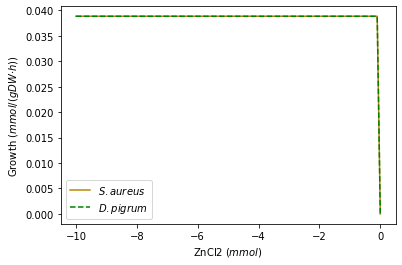

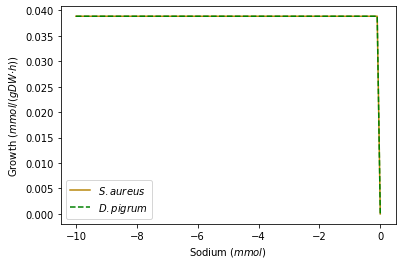

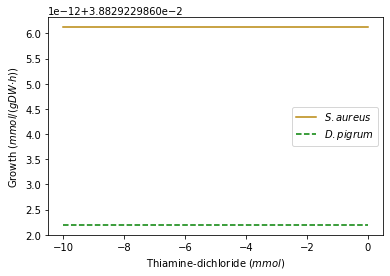

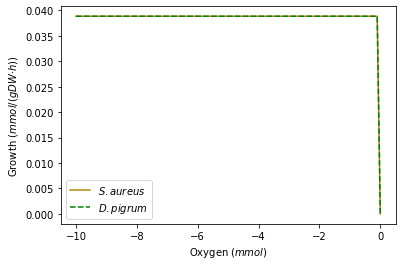

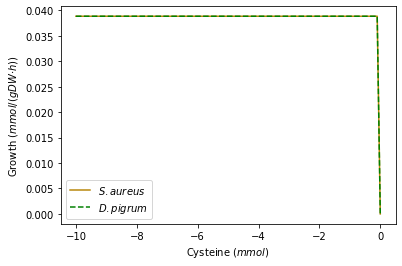

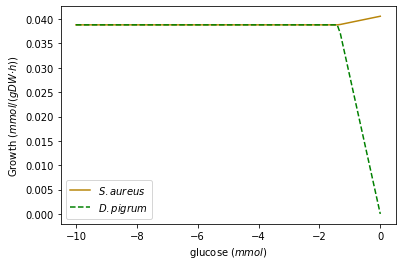

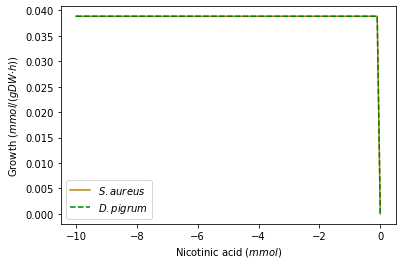

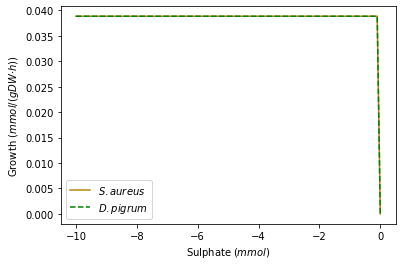

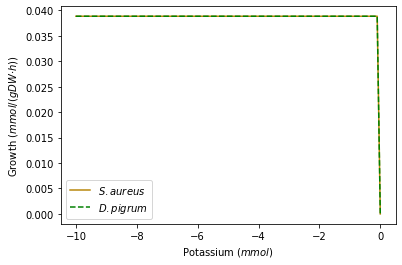

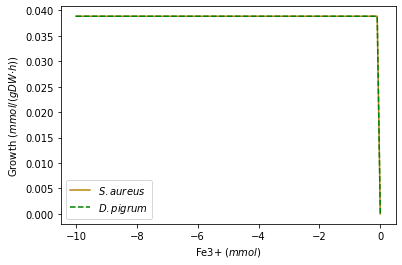

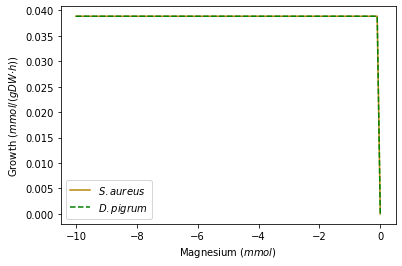

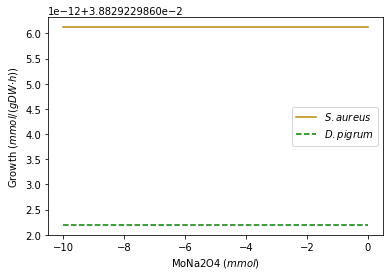

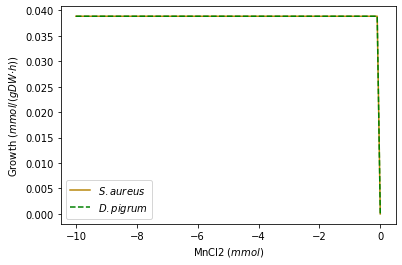

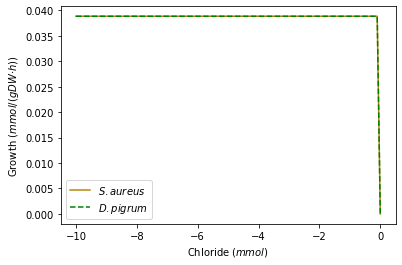

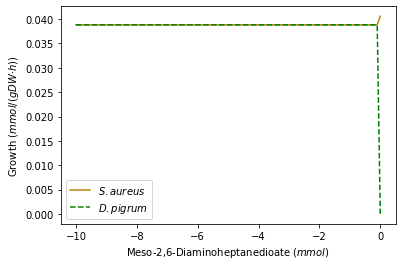

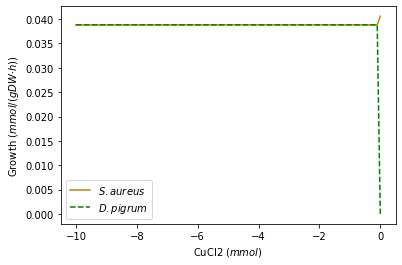

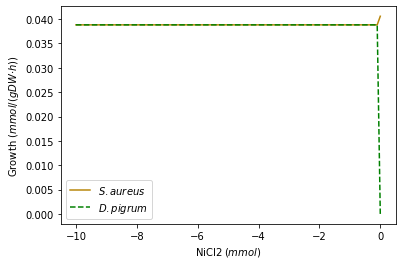

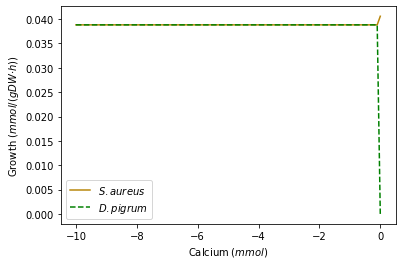

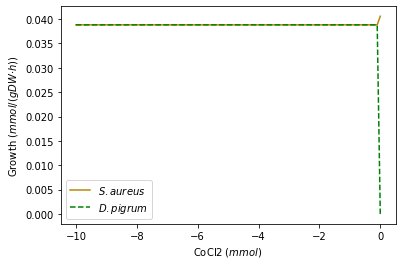

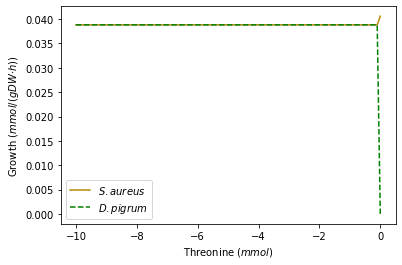

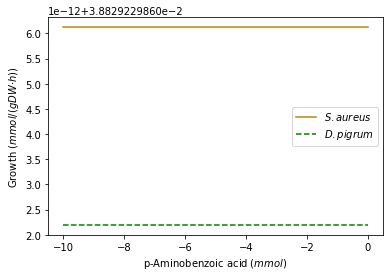

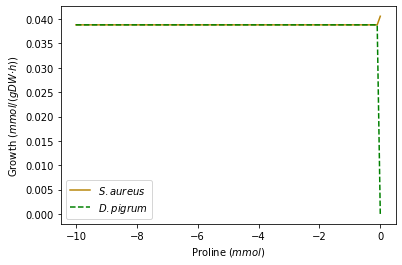

In [68]:
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} # Bottom vertical alignment for more space

for key in coopm:
    for j in range(len(Des)):
        ide =  "EX_" + str(Des.iloc[j][1]) + "_e"
        if key == ide:
    #plt.title(key, **title_font)
            plt.plot(vals, SA_growths[key], 'darkgoldenrod')
            plt.plot(vals, DP_growths[key], 'g--')
            plt.legend(["$\it{S.aureus}$" , "$\it{D. pigrum}$"])
            plt.xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            plt.ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
            plt.savefig(key + "COOPM_alpha.pdf", bbox_inches='tight', dpi=1000) 
            plt.savefig(key + "COOPM_alpha.jpeg", bbox_inches='tight', dpi=1000) 
            plt.show()
            
 

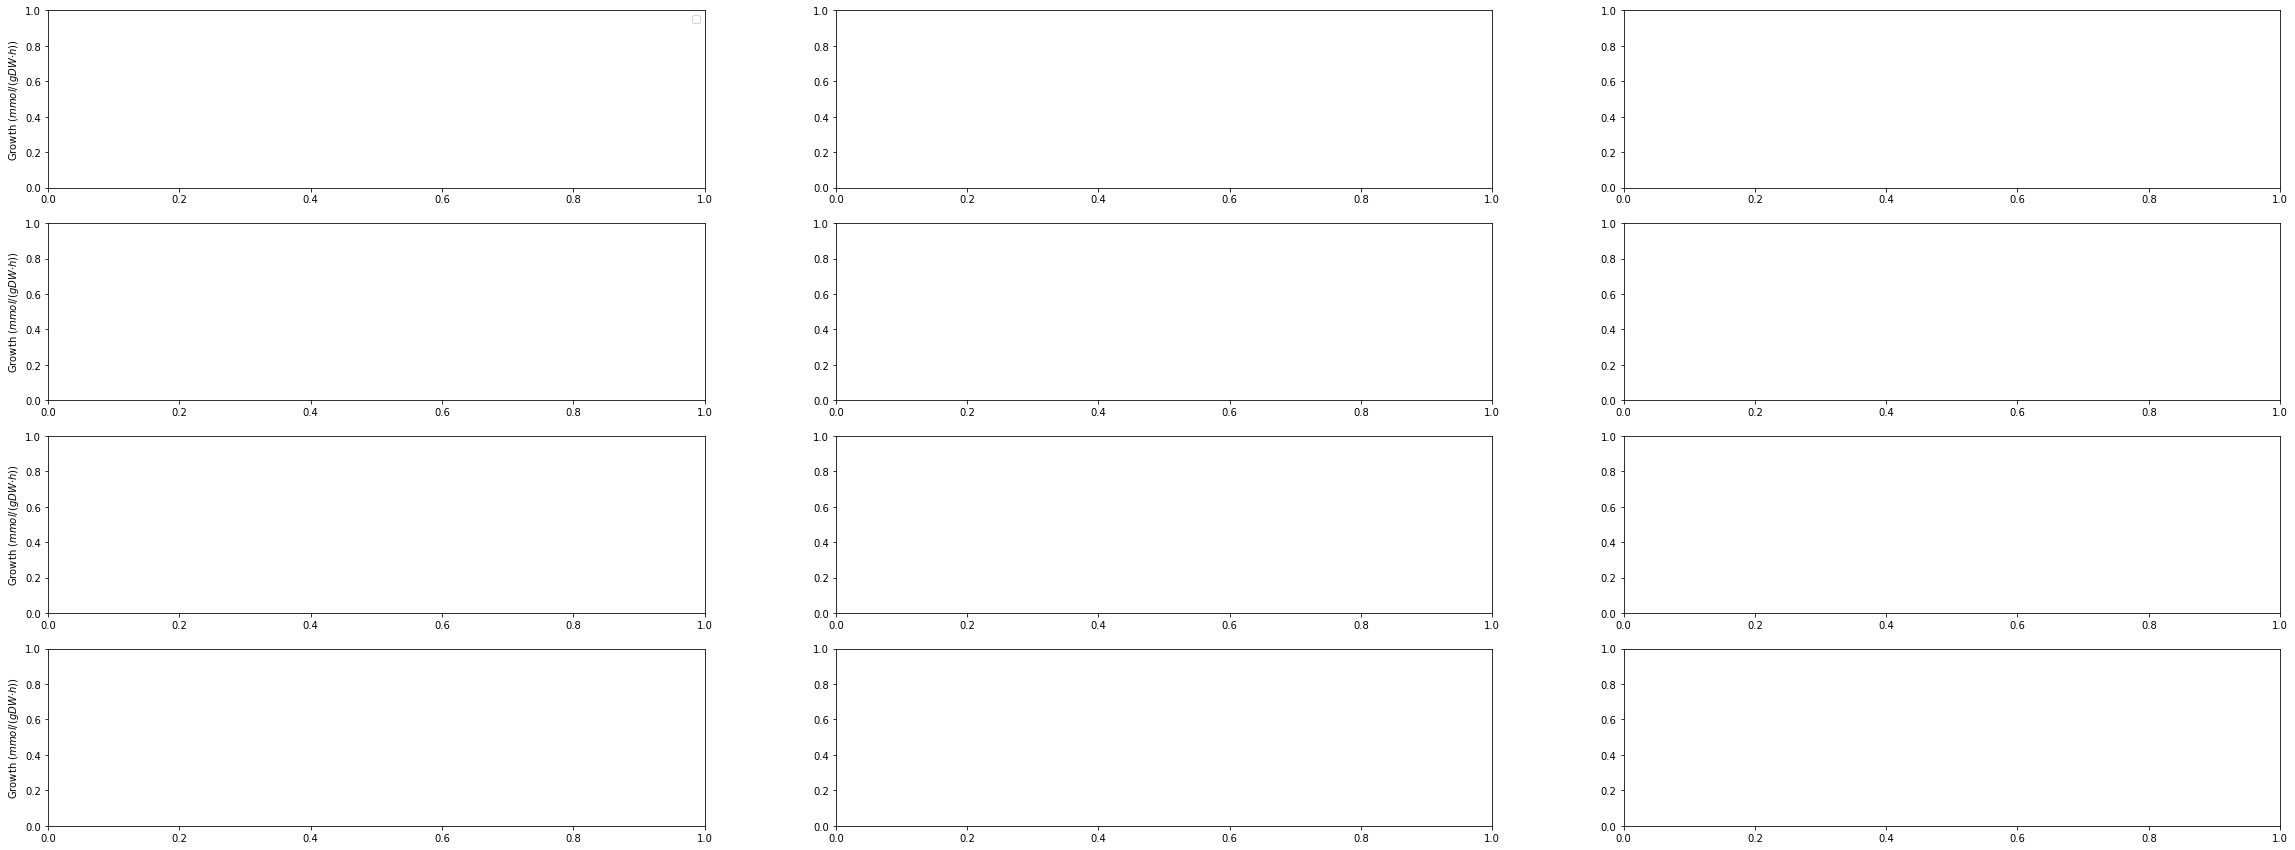

In [69]:
title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'} 

fig, axes = plt.subplots(4,3,figsize=(40,15))

   
for i in range(3):
    for j in range(len(Des)):
        ide = "EX_" + str(Des.iloc[j][1]) + "_e"
        if ide == key[i]:
            axes[0][i].set_xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            axes[0][i].plt.plot(vals, SA_growths[i], 'darkgoldenrod')
            axes[0][i].plt.plot(vals, DP_growths[i], 'g--')
axes[0][0].set_ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
for i in range(3):
    for j in range(len(Des)):
        ide = "EX_" + str(Des.iloc[j][1]) + "_e"
        if ide == key[i+3]:
            axes[0][i].set_xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            axes[0][i].plt.plot(vals, SA_growths[i+3], 'darkgoldenrod')
            axes[0][i].plt.plot(vals, DP_growths[i+3], 'g--')
axes[1][0].set_ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
for i in range(3):
    for j in range(len(Des)):
        ide = "EX_" + str(Des.iloc[j][1]) + "_e"
        if ide == key[i]:
            axes[0][i].set_xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            axes[0][i].plt.plot(vals, SA_growths[i+6], 'darkgoldenrod')
            axes[0][i].plt.plot(vals, DP_growths[i+6], 'g--')
axes[2][0].set_ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
for i in range(3):
    for j in range(len(Des)):
        ide = "EX_" + str(Des.iloc[j][1]) + "_e"
        if ide == key[i]:
            axes[0][i].set_xlabel(str(Des.iloc[j][0]) +  "$\;(\it{mmol})$")
            axes[0][i].plt.plot(vals, SA_growths[i+9], 'darkgoldenrod')
            axes[0][i].plt.plot(vals, DP_growths[i+9], 'g--')
    #axes[3][i].set_xlabel("Flux")
axes[3][0].set_ylabel("Growth $(\it{mmol/(gDW⋅h)})$")
axes[0][0].legend(["$\it{D. pigrum}$"])
plt.savefig("TEST_robust.pdf")
plt.savefig("TEST_robust.png")
